In [1]:
import pandas as pd
import itertools
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from multiprocessing import Manager

import datetime as dt
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import utils.helpers as hp
from utils.helpers import timer 
import model.queries as qrs

import os.path
from os import path

import logging
import os

logging.basicConfig(format = '%(asctime)s %(message)s',
                    datefmt = '%m/%d/%Y %I:%M:%S %p',
                    filename = '/data/petya/progress.log',
                    level=logging.INFO)


import pyarrow as pa
import pyarrow.parquet as pq

def write2Parquet(df, filename):
    table = pa.Table.from_pandas(df, preserve_index=True)
    pq.write_table(table, filename)

def saveData(df, file_name):
    with open(f"/data/petya/{file_name}.pkl","wb") as f:
        pickle.dump(df,f)
        
def loadData(df):
    with open(f'/data/petya/{df}.pkl', 'rb') as pickle_file:
        return pickle.load(pickle_file)

In [35]:
pip install ipwhois

In [34]:
pip install plotly

In [33]:
pip install pyarrow

In [2]:
def scan_gen(scan):
    while True:
        try:
            yield next(scan)['_source']
        except:
            break

def ps_trace_hashes(dt,src, dest,include=["timestamp","route-sha1","hops","destination_reached","src","dest","looping","path_complete"]):
    query = {
      "query" : {
        "bool" : {
          "must" : [
            {
              "range" : {
                "timestamp" : {
                  "gt" : dt[0],
                  "lte": dt[1]
                }
              }
            },
            {
              "term" : {
                'src' : {
                  "value" : src
                }
              }
            },
            {
              "term" : {
                'dest' : {
                  "value" : dest
                }
              }
            }
          ]
        }
      }
    }
#     print(str(query).replace("\'", "\""))
    try:
        return scan_gen(scan(hp.es,index="ps_trace",query=query, _source=include, filter_path=['_scroll_id', '_shards', 'hits.hits._source']))
    except Exception as e:
        print(e)
        
        
def getMeanLoss(dt, src, dest):
    q = {
          "size" : 0,
          "query" : {  
            "bool" : {
              "must" : [
                {
                  "range" : {
                    "timestamp" : {
                      "from" : dt[0],
                      "to" : dt[1]
                    }
                  }
                },
                {
                  "term" : {
                    "src" : src
                  }
                },
                {
                  "term" : {
                    "dest" : dest
                  }
                }
              ]
            }
          },
          "aggs": {
            "packet_loss": {
              "avg": {
                "field": "packet_loss"
              }
            }
          }
        }
#     print(str(q).replace("\'", "\""))
    
    data = hp.es.search(index='ps_packetloss', body=q, 
                _source=[ "packet_loss"])

    return data['aggregations']['packet_loss']['value']

    
def ps_packetloss(dt, src, dest, include=["timestamp","src","dest","packet_loss"]):
    query = {
      "query" : {
        "bool" : {
          "must" : [
            {
              "range" : {
                "timestamp" : {
                  "gt" : dt[0],
                  "lte": dt[1]
                }
              }
            },
            {
              "term" : {
                'src' : {
                  "value" : src
                }
              }
            },
            {
              "term" : {
                'dest' : {
                  "value" : dest
                }
              }
            }
          ]
        }
      }
    }
#     print(str(query).replace("\'", "\""))
    data = []
    try:
        gen = scan_gen(scan(hp.es,index="ps_packetloss",query=query, _source=include, filter_path=['_scroll_id', '_shards', 'hits.hits._source']))
        for meta in gen:
            data.append(meta)
            
        df = pd.DataFrame(data)
        if len(data)>0:
            df['dt'] = pd.to_datetime(df['timestamp'], unit='ms')
        return df
            
    except Exception as e:
        print(e)

        
def ps_trace(es, dt, src, dest):
    scan_gen = ps_trace_hashes(dt, src, dest)
    data = []
    hashes = {}
    records = 0

    for meta in scan_gen:
        data.append(meta)
#         print(meta)
        if 'route-sha1' in data[records]:
#         for doc in meta:
            hashes[meta['route-sha1']] = meta['hops']
        records += 1
        if not records % 500000:
            print(records)

    df = pd.DataFrame(data)
    if len(data)>0:
        df['dt'] = pd.to_datetime(df['timestamp'], unit='ms')
    return df

try:
    os.makedirs('/data/petya')
    os.makedirs('/data/petya/parquet')
except OSError as e:
    pass

startDate, endDate = '2021-05-02 07:00','2021-05-03 07:00'
with open('/data/petya/period.pkl','wb') as outfile:
    pickle.dump([startDate, endDate],outfile)

dt = hp.GetTimeRanges(startDate, endDate)

### Get all tested pairs

In [3]:
pairs = qrs.queryAllTestedPairs(dt)
%time pairsDf = pd.DataFrame(pairs)

write2Parquet(pairsDf, '/data/petya/pairsDf')

CPU times: user 20.3 ms, sys: 165 µs, total: 20.4 ms
Wall time: 20.5 ms


### Get ps_trace data pair by pair and store all pairs in a list

#### TODO: start a few threads for that to load

In [4]:
location = '/data/petya/parquet'
tracedata = []
def getTraceData():
#     tracedata = []
    i = 0
    for src, dest in pairsDf[pairsDf['idx']=='ps_packetloss'][['src', 'dest']].values:
        data = ps_trace(hp.es, dt, src, dest)
        filename = f'{location}/{src}-{dest}.parquet'
        if len(data)>0:
#             tracedata.append({'src': src, 'dest': dest, 'data':data})
            tracedata.append(data)
#             write2Parquet(data, filename)
        i+=1
    return tracedata

%time tracedata = getTraceData()


print('Number of src-dest pairs in ps_trace',len(tracedata))

CPU times: user 23.5 s, sys: 2.24 s, total: 25.7 s
Wall time: 7min 4s
Number of src-dest pairs in ps_trace 2466


### Calculate the packet loss between each two traceroute measures

##### Version Parquet

In [5]:
def splitUnknownPath(df):
    split_rows = []
    for idx, row in df[df['path_changed']==1].iterrows():
        if row['timestamp_prev']>0:
#             print(row, )
            begin = row['timestamp']
            end = row['timestamp_prev']
            midpoint = int(begin + (end - begin) / 2)

            # Add a flag that will tell that the measurement was split in two by timestamp. All other values remain the same
            row['path_changed'] = 2
            # Mark the row which was divided in two separate measures with 3, in order to be deleted later
            df.loc[idx, 'path_changed'] = 3

            # first interval
            row['timestamp_prev'] = midpoint
            split_rows.append(row)
            # second interval
            row['timestamp'] = midpoint
            row['timestamp_prev'] = end

            split_rows.append(row)

    df = df.append(split_rows, ignore_index=True)
    
    # remove the original rows
    df = df[df['path_changed']<3]
    
    return df


def calculatePathLoss(trace_df):
    src = trace_df['src'][0]
    dest = trace_df['dest'][0]
    logging.info(f'{src}  ->  {dest}  len: {len(trace_df)}')
    trace_df = trace_df.sort_values('timestamp', ascending=True)
    # get the previous row value
    trace_df['timestamp_prev'] = trace_df.timestamp.shift(1,fill_value=0)
    trace_df['route-sha1_prev'] = trace_df['route-sha1'].shift(1)
    plossDf = ps_packetloss([trace_df['timestamp'].min(), trace_df['timestamp'].max()],src, dest)

    def calcLoss(row):
        loss = None
        pathChanged = 1
        if row['timestamp_prev']>0:
            loss = plossDf[(plossDf['timestamp']<=row['timestamp']) & (plossDf['timestamp']>=row['timestamp_prev'])]['packet_loss'].mean()
            if row['route-sha1'] == row['route-sha1_prev']:
                pathChanged = 0

        return pd.Series([loss, pathChanged])

    # in some cases there are no packetloss measures for the min-max time in traceroute measures
    if len(plossDf) > 0:
        trace_df[['loss', 'path_changed']] = trace_df.apply(calcLoss, axis=1)

        if len(trace_df[trace_df['path_changed']==1])>1:
            trace_df = splitUnknownPath(trace_df)

        filename = f"/data/petya/parquet/{trace_df['src'].unique()[0]}-{trace_df['dest'].unique()[0]}.parquet"

        # write to a pickle file
        if path.exists(filename):
            if os.path.getsize(filename) > 0:          
                ff = pq.read_pandas(filename).to_pandas()

                if len(ff) != len(trace_df) or any(x not in ff.columns for x in ['loss', 'path_changed']):
    #                     print('File not OK. Write!', len(ff), len(trace_df))
                    trace_df = write2Parquet(trace_df, filename)
            else: trace_df = write2Parquet(trace_df, filename)
        else:
            trace_df = write2Parquet(trace_df, filename)

        return trace_df

### Run the calculations in parallel

In [6]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

pairsWithNoPathsRemoved = []
for i, df in enumerate(tracedata):
    if 'route-sha1' in df.columns:
        pairsWithNoPathsRemoved.append(df)
# print(f'There are {len(tracedata)-len(pairsWithNoPathsRemoved)} pairs missing route-sha1 field')

def addPacketLoss2Df():
    with ProcessPoolExecutor(max_workers=4) as pool:
        result = [res for res in pool.map(calculatePathLoss, pairsWithNoPathsRemoved) if res is not None]
    return result


%time tracedata = addPacketLoss2Df()

CPU times: user 9.81 s, sys: 2.37 s, total: 12.2 s
Wall time: 5min 42s


## Merge all pairs into a Dask dataframe

In [7]:
import dask
import dask.dataframe as dd

files = []
for filename in os.listdir('/data/petya/parquet/'):
    df = pd.read_parquet(f'/data/petya/parquet/{filename}')
    # in some cases there are no packetloss measures for the min-max time in traceroute measures
    if 'loss' in df.columns:
        files.append(f'/data/petya/parquet/{filename}')
    
    
mergedDf = dd.read_parquet(files, npartitions=4*4).compute()

In [8]:
mergedDf.tail()

,path_complete,destination_reached,src,looping,hops,dest,route-sha1,timestamp,dt,timestamp_prev,route-sha1_prev,loss,path_changed
288,True,True,2620:6a:0:8420::45,False,"[2620:6a:0:8420::6, 2620:6a:0:8422:131:225:15:...",2620:0:210:1::26,7421e47076894b16aab5d865f5c543ac113677a1,1620023360500,2021-05-03 06:33:21,1620023120000,d327dcb3a481c8e6ff00180115f27575603782cb,0.000469,2.0
289,True,True,2620:6a:0:8420::45,False,"[2620:6a:0:8420::6, 2620:6a:0:8422:131:225:15:...",2620:0:210:1::26,89f44562c3061072359ac0b6fc591381058ea9ed,1620023950500,2021-05-03 06:45:00,1620023601000,7421e47076894b16aab5d865f5c543ac113677a1,0.000556,2.0
290,True,True,2620:6a:0:8420::45,False,"[2620:6a:0:8420::6, 2620:6a:0:8422:131:225:15:...",2620:0:210:1::26,89f44562c3061072359ac0b6fc591381058ea9ed,1620023950500,2021-05-03 06:45:00,1620023601000,7421e47076894b16aab5d865f5c543ac113677a1,0.000556,2.0
291,True,True,2620:6a:0:8420::45,False,"[2620:6a:0:8420::6, 2620:6a:0:8422:131:225:15:...",2620:0:210:1::26,7421e47076894b16aab5d865f5c543ac113677a1,1620024574500,2021-05-03 06:54:09,1620024300000,89f44562c3061072359ac0b6fc591381058ea9ed,0.000381,2.0
292,True,True,2620:6a:0:8420::45,False,"[2620:6a:0:8420::6, 2620:6a:0:8422:131:225:15:...",2620:0:210:1::26,7421e47076894b16aab5d865f5c543ac113677a1,1620024574500,2021-05-03 06:54:09,1620024300000,89f44562c3061072359ac0b6fc591381058ea9ed,0.000381,2.0


### Build a dictionarry of hashes and their set of IP addresses

In [9]:
import os
import pickle
manager = Manager() 
hashDict = manager.dict()

def getHashes2IPlist(filename):
    df = pd.read_parquet(f'/data/petya/parquet/{filename}')
    
    for path in df['route-sha1'].unique().tolist():
        hops = df[df['route-sha1']==path]['hops'].to_list()
        if len(hops)>0:
            hashDict[path] = hops[0].tolist()


def run():
    files = os.listdir('/data/petya/parquet/')
    with ProcessPoolExecutor(max_workers=4) as pool:
        pool.map(getHashes2IPlist, files)

    print(f'Number of unique paths: {len(hashDict)}')
    saveData(hashDict, 'hashDict')
    return dict(hashDict)

%time hashDict = run()

Number of unique paths: 45461
CPU times: user 1.32 s, sys: 953 ms, total: 2.27 s
Wall time: 12 s


### Get only the good paths, loop and extract the hops

In [10]:
# badPathsRemoved = mergedDf[(mergedDf['looping']==False)&(mergedDf['path_complete']==True)]
# aggmerged = badPathsRemoved.groupby(['route-sha1', 'src', 'dest']).agg({'loss': 'mean'}).reset_index()


paths = mergedDf.groupby(['route-sha1', 'src', 'dest']).agg({'loss': 'mean'}).reset_index()
logging.info(f'Number of paths {len(paths)}')
hopsList = []

def f(row):
    path = row['route-sha1']
    hops = hashDict[path]
    if len(hops)>0:
#         hops = None

        # add source to the list of hops to mark the first hop
        if row['src'] != hops[0]:
            hops.insert(0, row['src'])

        for i, ip in enumerate(hops):
            if i < len(hops)-1:
                # do not add looping values 
                if hops[i] != hops[i+1]:
                    hopsList.append({'src': row['src'], 'dest': row['dest'], 'hash': row['route-sha1'],
                                     'pos': i, 'hop': (hops[i], hops[i+1]), 'path_mean': row['loss']
                                    })
    if row.name%5000 == 0:
        logging.info(f'Reached {row.name}')


# get information about the hops
paths.apply(f, axis=1)
hopsDf = pd.DataFrame.from_dict(hopsList, orient='columns')
hopsDf[['start', 'end']] = pd.DataFrame(hopsDf['hop'].tolist(), index=hopsDf.index)

saveData(hopsDf, 'hopsDf')

In [11]:
hopsDf.head()

,src,dest,hash,pos,hop,path_mean,start,end
0,138.253.60.82,206.12.127.30,0000e19bc0f3226fb052e9d4f3a96d758ec68b1b,0,"(138.253.60.82, 138.253.60.2)",0.0,138.253.60.82,138.253.60.2
1,138.253.60.82,206.12.127.30,0000e19bc0f3226fb052e9d4f3a96d758ec68b1b,1,"(138.253.60.2, 138.253.1.17)",0.0,138.253.60.2,138.253.1.17
2,138.253.60.82,206.12.127.30,0000e19bc0f3226fb052e9d4f3a96d758ec68b1b,2,"(138.253.1.17, 146.97.169.141)",0.0,138.253.1.17,146.97.169.141
3,138.253.60.82,206.12.127.30,0000e19bc0f3226fb052e9d4f3a96d758ec68b1b,3,"(146.97.169.141, 146.97.78.49)",0.0,146.97.169.141,146.97.78.49
4,138.253.60.82,206.12.127.30,0000e19bc0f3226fb052e9d4f3a96d758ec68b1b,4,"(146.97.78.49, 146.97.38.45)",0.0,146.97.78.49,146.97.38.45


### Get mean, median, mode for each hop and assign an id 

In [17]:
import concurrent.futures
import math

# assign an id to each hop
hopsId = {x: i for i, x in enumerate(hopsDf['hop'].unique())}

def getStats(hop):
    hashList =  hopsDf[(hopsDf['hop']==hop)]['hash'].to_list()
    loss = mergedDf[mergedDf['route-sha1'].isin(hashList)]['loss']

    mean, median, mode = None, None, None
    if loss.isnull().values.all()==False:
        mean = loss.mean()
        median = loss.median()
        mode = loss.mode()[0]

    if hopsId[hop]%1000 == 0:
        logging.info(f'Passed:, {hopsId[hop]}')
        
    return {
        'hop_id': hopsId[hop],
        'hop': hop,
        'mean': mean,
        'median': median,
        'mode': mode
    }


def multi_processing():
    items = []
    uhops = hopsDf['hop'].unique()
    print('Number of hops: ',len(uhops))
    with  concurrent.futures.ProcessPoolExecutor(max_workers=4) as p:
        processing = p.map(getStats, uhops)
    print('Done')
    for data in processing:
        items.append(data)
        
    return items

%time hopStats = multi_processing()

hopStatsDf = pd.DataFrame(hopStats)
saveData(hopStatsDf, 'hopStatsDf')

Number of hops:  8164
Done
CPU times: user 4.76 s, sys: 1.42 s, total: 6.18 s
Wall time: 2min 28s


### Get the number of unique paths for each hop

In [13]:
numHashesDf = hopsDf.groupby(['hop']).agg({'hash': 'count'})
numHashesDf.rename(columns={'hash':'num_hashes'}, inplace=True)
relDf = pd.merge(hopStatsDf, numHashesDf, on='hop')
relDf.sort_values('mean', ascending=False)

saveData(relDf, 'relDf')

### Plot path mean loss to unique paths relationship

<AxesSubplot:xlabel='mean', ylabel='num_hashes'>

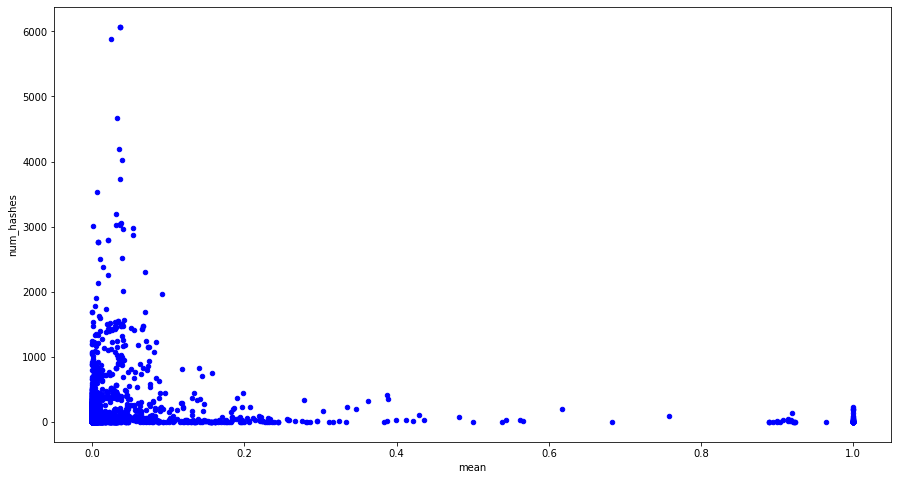

In [14]:
relDf.plot.scatter( x="mean", y="num_hashes", rot=0, color="b", figsize=(15,8))

### Check the distribution of number of unique hashes

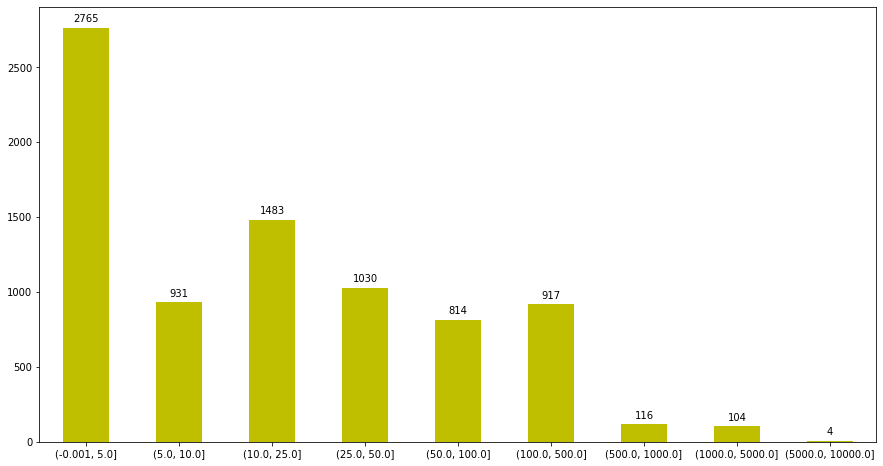

In [15]:
out = pd.cut(relDf['num_hashes'], bins=[0, 5, 10, 25, 50, 100, 500, 1000, 5000, 10000], include_lowest=True)
ax3 = out.value_counts(sort=False).plot.bar(rot=0, color="y", figsize=(15,8))
for p in ax3.patches:
    ax3.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')